# 8. Classical Simulation

Yoshiaki Kawase (Jun 07, 2024)

The module is housed on GitHub [here](https://github.com/puyokw/2024UTokyo_lecture8/tree/main). This lesson can be considered optional, but highly recommended.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import math
import random
import time

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

#from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.quantum_info import SparsePauliOp


## 1 Matrix Product State simulator

First, we will use the Matrix Prodcut State simulator to see how it works.

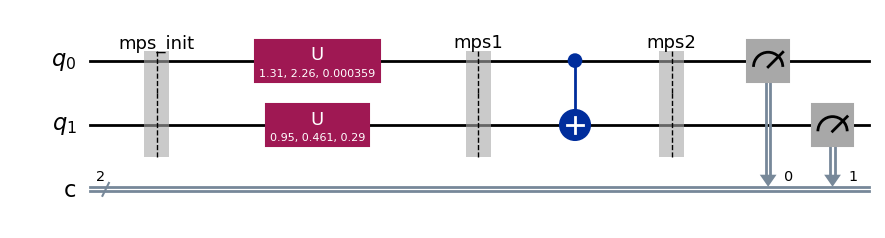

In [4]:
mps_simulator = AerSimulator(method='matrix_product_state')
n_qubits=2
seed = 1
np.random.seed(seed)
random.seed(seed)
angles = np.random.rand(9)*math.pi

qc = QuantumCircuit(n_qubits, n_qubits)
qc.save_matrix_product_state(label='mps_init')
qc.u(angles[0], angles[1], angles[2], 0) # prepare a random quantum state
qc.u(angles[3], angles[4], angles[5], 1) # prepare a random quantum state
qc.save_matrix_product_state(label='mps1')
qc.cx(0,1)
qc.save_matrix_product_state(label='mps2')
qc.measure(range(n_qubits), range(n_qubits))
qc.draw(output="mpl")
plt.show()


In [5]:
tqc = transpile(qc, mps_simulator)
result = mps_simulator.run(tqc).result()
result.data(0)['mps_init']

([(array([[1.+0.j]]), array([[0.+0.j]])),
  (array([[1.+0.j]]), array([[0.+0.j]]))],
 [array([1.])])

From the [qiskit document](https://qiskit.github.io/qiskit-aer/tutorials/7_matrix_product_state_method.html#id1),
when we use a matrix product state simulator, 
a quantum state is represented by a canonical form $\Gamma^{(1)} \lambda^{(1)} \cdots \Gamma^{(n-1)} \lambda^{(n-1)} \Gamma^{(n)}$, 
where $\Gamma$ represents a tensor and $\lambda$ represents a normalizing factor.
So, the simulator has lists of tensors and normalizing factors. 

The output of the simulator containing a list of tensors A and B and a list of normalizing factor $\lambda$.
If we describe a quantum state by $ |\psi_{init}\rangle = \sum_{\sigma_0,\sigma_1} A^{\sigma_0} \lambda B^{\sigma_1} |\sigma_0 \sigma_1 \rangle$,
it contains a list of tensors $[A,B]=[A^0,A^1,B^0,B^1]$ and a normalizing factor $[\lambda]$. 

We can see that the initial state $|00\rangle$ is described by
$ |\psi_{init}\rangle = \sum_{\sigma_0,\sigma_1} A^{\sigma_0} \lambda B^{\sigma_1} |\sigma_0 \sigma_1 \rangle$, 
where $A^{0} = 1, A^{1}=0, B^{0}=1, B^{1}=0, \lambda=1$. 

In [6]:
A0 = 1
A1 = 0
B0 = 1
B1 = 0

Next, we will act an unitary gate U on 0-th qubit. An unitary gate can be described by $2 \times 2$ matrix

$
U=
\begin{pmatrix}
u_{00} & u_{01} \\
u_{10} & u_{11}
\end{pmatrix}
=u_{00} |0\rangle \langle 0|+u_{01} |0\rangle \langle 1|+u_{10} |1\rangle \langle 0|+u_{11} |1\rangle \langle 1|
$.

$
(U\otimes I)|\psi_{init} \rangle 
= \sum_{\sigma_0} U A^{\sigma_0} |\sigma_0\rangle \otimes \sum_{\sigma_1} B^{\sigma_1} |\sigma_1 \rangle
= \bigg( ( A^{0}u_{00} + A^{1}u_{01} )|0\rangle + (A^{0}u_{10} + A^{1}u_{11} ) |1\rangle \bigg) \otimes \sum_{\sigma_1} B^{\sigma_1} |\sigma_1 \rangle
$

From the definition of U gate in qiskit, 

$
U(\theta_1,\theta_2,\theta_3)=
\begin{pmatrix}
\cos{(\theta_1/2)} & -e^{i\theta_3}\sin{(\theta_1/2)} \\
e^{i\theta_2}\sin{(\theta_1/2)} & e^{i(\theta_2+\theta_3)} \cos{(\theta_1/2)}
\end{pmatrix}
$

we assign the values of $\theta_1, \theta_2$ and $\theta_3$, and then apply the U gate to the quantum state:

In [7]:
# From the definition of U gate in qiskit, 
u00 = np.cos(angles[0]/2)
u01 = -np.exp(1.0j*angles[2])*np.sin(angles[0]/2)
u10 = np.exp(1.0j*angles[1])*np.sin(angles[0]/2)
u11 = np.exp(1.0j*(angles[1]+angles[2]))*np.cos(angles[0]/2)
print( "new A^0=", A0*u00+A1*u01, "new A^1=", A0*u10+A1*u11)

new A^0= (0.7930134282051604+0j) new A^1= (-0.3887996598361402+0.4690037603235188j)


Similarly, we calculate $B^0$ and $B^1$ as follows: 

In [8]:
# From the definition of U gate, 
v00 = np.cos(angles[3]/2)
v01 = -np.exp(1.0j*angles[5])*np.sin(angles[3]/2)
v10 = np.exp(1.0j*angles[4])*np.sin(angles[3]/2)
v11 = np.exp(1.0j*(angles[4]+angles[5]))*np.cos(angles[3]/2)
print( "new B^0=", B0*v00+B1*u01, "new B^1=", B0*v10+B1*v11)

new B^0= (0.8893371274812134+0j) new B^1= (0.4095090690923406+0.20342516072155029j)


Let's see the vlaues of tensors A and B and a normalizing factor $\lambda$ in the simulator. 

In [9]:
result.data(0)['mps1']

([(array([[0.79301343+0.j]]), array([[-0.38879966+0.46900376j]])),
  (array([[0.88933713+0.j]]), array([[0.40950907+0.20342516j]]))],
 [array([1.])])

Similar to the above case, 
the output of the simulator consisting of a list of tensors A and B and a list including normalization factor $\lambda$.
If we describe a quantum state by $ |\psi_{1}\rangle = \sum_{\sigma_0,\sigma_1} A^{\sigma_0} \lambda B^{\sigma_1} |\sigma_0 \sigma_1 \rangle$,
it contains a list of tensors $[A,B]=[A^0,A^1,B^0,B^1]$ and a normalization factor $[\lambda]$. 

From the output, its tensors and normalization factor are 

In [10]:
print("A^0=", result.data(0)['mps1'][0][0][0][0], ", A^1=", result.data(0)['mps1'][0][0][1][0], 
      "\nB^0=", result.data(0)['mps1'][0][1][0][0], ", B^1=", result.data(0)['mps1'][0][1][1][0], 
      "\nlambda=", result.data(0)['mps1'][1][0])

A^0= [0.79301343+0.j] , A^1= [-0.38879966+0.46900376j] 
B^0= [0.88933713+0.j] , B^1= [0.40950907+0.20342516j] 
lambda= [1.]


We can see that the results are consistent with the above calculations.

In [11]:
print( "new A^0=", A0*u00+A1*u01, ", new A^1=", A0*u10+A1*u11)
print( "new B^0=", B0*v00+B1*u01, ", new B^1=", B0*v10+B1*v11)

new A^0= (0.7930134282051604+0j) , new A^1= (-0.3887996598361402+0.4690037603235188j)
new B^0= (0.8893371274812134+0j) , new B^1= (0.4095090690923406+0.20342516072155029j)


Then, we update the values of tensors in order to see how the simulator works:

In [12]:
A0 = result.data(0)['mps1'][0][0][0][0][0]
A1 = result.data(0)['mps1'][0][0][1][0][0]
B0 = result.data(0)['mps1'][0][1][0][0][0]
B1 = result.data(0)['mps1'][0][1][1][0][0]
print(A0, A1, B0, B1)

(0.7930134282051604+0j) (-0.3887996598361402+0.4690037603235188j) (0.8893371274812134+0j) (0.4095090690923406+0.20342516072155029j)


Next, we apply CNOT gate to the quantum state. 

CNOT gate is described by
$CX_{c,t} = |0_c\rangle \langle 0_c| \otimes I_t + |1_c\rangle \langle 1_c| \otimes X_t$. 
If we apply $CX_{0,1}$ to $|\psi_1 \rangle$, 

$|\psi_2 \rangle := CX_{0,1} |\psi_1\rangle= 
(|0\rangle \langle 0| \otimes I + |1\rangle \langle 1| \otimes X)
(A^0 B^0|00\rangle+A^0 B^1 |01\rangle+A^1 B^0|10\rangle+A^1 B^1|11\rangle)$

$=(A^0 B^0|00\rangle+A^0 B^1 |01\rangle+A^1 B^1|10\rangle+A^1 B^0|11\rangle)$

Here, we calculate the amplitudes of the quantum state after applying the CNOT gate. 

In [13]:
c00 = A0*B0
c01 = A0*B1
c10 = A1*B1
c11 = A1*B0
print(c00, c01, c10, c11)

(0.7052562842940068+0j) (0.3247461907620209+0.16131888408698233j) (-0.25462415208573974+0.11296966000024052j) (-0.3457739726443458+0.4171024569840057j)


Then, we will decompose $(A^0 B^0|00\rangle+A^0 B^1 |01\rangle+A^1 B^1|10\rangle+A^1 B^0|11\rangle)$ into matrix product state form using SVD. 

Here, we consider $|\psi\rangle = c_{00} |00\rangle + c_{01} |01\rangle + c_{10} |10\rangle + c_{11} |11\rangle$ and 
a matrix consisting of the coefficients
$M=\begin{pmatrix}
c_{00} & c_{01} \\
c_{10} & c_{11}
\end{pmatrix}$. 
If we apply singular value decomposition(SVD) to it, then we obtain

$
\begin{pmatrix}
c_{00} & c_{01} \\
c_{10} & c_{11}
\end{pmatrix}
=UDV^\dagger=
\begin{pmatrix}
u_{00} & u_{01} \\
u_{10} & u_{11}
\end{pmatrix}
\begin{pmatrix}
\lambda_{0} & 0 \\
0 & \lambda_{1}
\end{pmatrix}
\begin{pmatrix}
v_{00} & v_{01} \\
v_{10} & v_{11}
\end{pmatrix}
$

So, the coefficients can be written by $c_{\sigma_0 \sigma_1}=\sum_{k=0}^1 u_{\sigma_0 k} \lambda_{k} v_{k\sigma_1}$. 
We assign it to $|\psi\rangle = c_{00} |00\rangle + c_{01} |01\rangle + c_{10} |10\rangle + c_{11} |11\rangle$, and we obtain

$
|\psi \rangle=\sum_{\sigma_0=0}^1\sum_{\sigma_j=0}^1 c_{\sigma_0\sigma_1} |\sigma_0\rangle |\sigma_1\rangle 
=\sum_{\sigma_0=0}^1 \sum_{\sigma_1=0}^1 \sum_{k=0}^1 u_{\sigma_0 k} \lambda_k v_{k \sigma_1} |\sigma_0\rangle |\sigma_1\rangle
$.

Therefore,
by assigning $u_{00}=A_0^0, u_{01}=A_1^0, u_{10}=A_0^1, u_{11}=A_1^1, v_{00}=B_0^0, v_{01}=B_0^1, v_{10}=B_1^0, v_{11}=B_1^1$, 
we can describe $ |\psi_2 \rangle$ as $\sum_{\sigma_1=0}^1 \sum_{\sigma_0=0}^1 \sum_{k=0}^1 A^{\sigma_0}_k \lambda_k B^{\sigma_1}_k |\sigma_0 \sigma_1 \rangle$, 

In order to calculate the values of A, B, and $\lambda$, we make a coefficient matrix 
$
\begin{pmatrix}
c_{00} & c_{01} \\
c_{10} & c_{11}
\end{pmatrix}
$ 
and apply SVD to it.

In [14]:
M = np.array([
    [c00,c01],
    [c10,c11]
])
M

array([[ 0.70525628+0.j        ,  0.32474619+0.16131888j],
       [-0.25462415+0.11296966j, -0.34577397+0.41710246j]])

In [15]:
res = np.linalg.svd(M)
rank = len(res.S)
# res.U @np.diag(res.S)@res.Vh[:rank,:]
res

SVDResult(U=array([[-0.81577887-0.08031113j, -0.51037011+0.25995635j],
       [ 0.40698376-0.40301262j, -0.1797446 +0.79977304j]]), S=array([0.9352768, 0.3539171]), Vh=array([[-0.77462551+0.j        , -0.62729957-0.08031542j],
       [-0.6324202 +0.j        ,  0.76835346+0.09837506j]]))

From the result of SVD and the above explanation, we determin the coefficients as follows:

In [16]:
A00 = res.U[0][0]
A01 = res.U[0][1]
A10 = res.U[1][0]
A11 = res.U[1][1]
lam = res.S
B00 = res.Vh[0][0]
B01 = res.Vh[1][0]
B10 = res.Vh[0][1]
B11 = res.Vh[1][1]

In [17]:
result.data(0)['mps2']

([(array([[ 0.81577887+0.08031113j, -0.51037011+0.25995635j]]),
   array([[-0.40698376+0.40301262j, -0.1797446 +0.79977304j]])),
  (array([[ 0.77462551-0.j],
          [-0.6324202 -0.j]]),
   array([[0.62729957+0.08031542j],
          [0.76835346+0.09837506j]]))],
 [array([0.9352768, 0.3539171])])

This output consisting of lists including tensors A and B and including normalizing factors $\lambda$.

If we describe a quantum state by  $\sum_{\sigma_0=0}^1 \sum_{\sigma_1=0}^1 \sum_{k=0}^1 A^{\sigma_0}_k \lambda_k B^{\sigma_1}_k |\sigma_0 \sigma_1 \rangle$,
it contains lists including tensors $[A,B]=[[[A^0_0,A^0_1],[A^1_0,A^1_1]],[[B^0_0,B^0_1],[B^1_0,B^1_1]]]$ and including normalizaition factors $[\lambda_0,\lambda_1]$. 

We can see that the eigen values are matched: 

In [18]:
print(lam, result.data(0)['mps2'][1])

[0.9352768 0.3539171] [array([0.9352768, 0.3539171])]


From the simulator outputs, the vlaues of the tensors are

In [19]:
print(f"A^0_0={0.81577887+0.08031113j}, A^0_1={-0.51037011+0.25995635j}, A^1_0={-0.40698376+0.40301262j}, A^1_1={-0.1797446 +0.79977304j}")
print(f"B^0_0={0.77462551}, B^0_1={-0.6324202}, B^1_0={0.62729957+0.08031542j}, B^1_1={0.76835346+0.09837506j}")

A^0_0=(0.81577887+0.08031113j), A^0_1=(-0.51037011+0.25995635j), A^1_0=(-0.40698376+0.40301262j), A^1_1=(-0.1797446+0.79977304j)
B^0_0=0.77462551, B^0_1=-0.6324202, B^1_0=(0.62729957+0.08031542j), B^1_1=(0.76835346+0.09837506j)


Here we describe our calculation results: 

In [20]:
print(f"A^0_0={A00:.8f}, A^0_1={A01:.8f}, A^1_0={A10:.8f}, A^1_1={A11:.8f}\n")
print(f"B^0_0={B00:.8f}, B^0_1={B01:.8f}, B^1_0={B10:.8f}, B^1_1={B11:.8f}")

A^0_0=-0.81577887-0.08031113j, A^0_1=-0.51037011+0.25995635j, A^1_0=0.40698376-0.40301262j, A^1_1=-0.17974460+0.79977304j

B^0_0=-0.77462551+0.00000000j, B^0_1=-0.63242020+0.00000000j, B^1_0=-0.62729957-0.08031542j, B^1_1=0.76835346+0.09837506j


$A_0^0, A_0^1, B_0^0,$ and $B_0^1$ have opposite signs compared to the corresponding values in simulator, 
but the simulator and the above result represent the same quantum state.

$|\psi_2\rangle = 
\lambda_0 \bigg( (A^0_0 |0\rangle + A^1_0 |1\rangle) \otimes (B^0_0 |0\rangle + B^1_0 |1\rangle) \bigg)
+\lambda_1 \bigg( (A^0_1 |0\rangle + A^1_1 |1\rangle) \otimes (B^0_1 |0\rangle + B^1_1 |1\rangle) \bigg)$

$=\lambda_0 \bigg( (-A^0_0 |0\rangle - A^1_0 |1\rangle) \otimes (-B^0_0 |0\rangle - B^1_0 |1\rangle) \bigg)
+\lambda_1 \bigg( (A^0_1 |0\rangle + A^1_1 |1\rangle) \otimes (B^0_1 |0\rangle + B^1_1 |1\rangle) \bigg)$

## 2. Stabilizer simulator

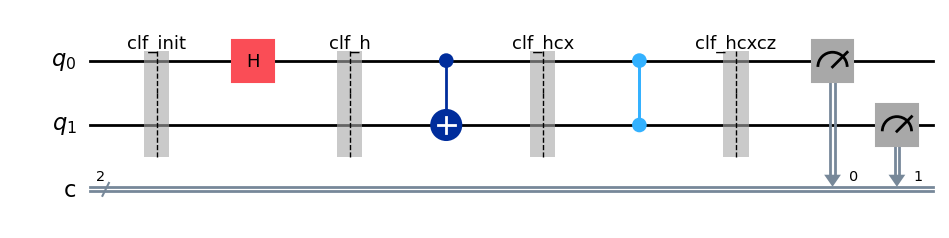

In [21]:
stab_simulator = AerSimulator(method='stabilizer')

n_qubits = 2
qc = QuantumCircuit(n_qubits, n_qubits)
qc.save_clifford(label='clf_init')
qc.h(0)
qc.save_clifford(label='clf_h')
qc.cx(0, 1)
qc.save_clifford(label='clf_hcx')
qc.cz(0, 1)
qc.save_clifford(label='clf_hcxcz')
qc.measure(range(n_qubits), range(n_qubits))
tcirc = transpile(qc, stab_simulator)
result = stab_simulator.run(tcirc).result()
qc.draw(output="mpl")
plt.show()

The stabilizer operators of initial state $|00\rangle$ are $I_2Z_1, Z_2I_1$, so binary table is represented as follows:

| |$x_1x_2$|$z_1z_2$|
|-|-|-|
|$Z_1I_2$|$00$|$10$|
|$I_1Z_2$|$00$|$01$|

In [22]:
result.data(0)['clf_init'].stab.astype(int)

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0]])

In the simulator, there is an additional column at the end of the table to handle the global phase.

By swaping the clomun between $x_1$ and $z_1$, 
we can see the quantum state after H gate is acted on 1st qubit. 

In [23]:
result.data(0)['clf_h'].stab.astype(int)

array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

Current stabilizer is $X_1I_2,I_1Z_2$, so current quantum state is $|0\rangle \otimes \frac{|0\rangle+|1\rangle}{\sqrt{2}}$. (Note that the right most qubit is 1st qubit)

We act CNOT gate on 1st qubit as control and 2nd qubit as target qubit. 
The binary table is updated by $x_2^{new}=x_1\oplus x_2, z_1^{new}=z_1\oplus z_2$.

In [24]:
result.data(0)['clf_hcx'].stab.astype(int)

array([[1, 1, 0, 0, 0],
       [0, 0, 1, 1, 0]])

The stabilizer operator is $X_1X_2$ and $Z_1 Z_2$, so current quantum state is $\frac{|00\rangle+|11\rangle}{\sqrt{2}}$. 

We act CZ gate on 1st qubit as control qubit and 2nd qubit as target qubit. 

The bianry table is updated by $z_1^{new}=x_2\oplus z_1, z_2^{new}=x_1\oplus z_2$. 

In [25]:
result.data(0)['clf_hcxcz'].stab.astype(int)

array([[1, 1, 1, 1, 0],
       [0, 0, 1, 1, 0]])

The stabilier operators are $Y_1Y_2, Z_1Z_2$, so current quantum state is $(|00\rangle-|11\rangle)/\sqrt{2}$. 

In [26]:
result.data(0)['counts']

{'0x3': 521, '0x0': 503}

Clifford gates also include single qubit gates whose rotation angle is $m\pi/2$, where $m$ is an integer.

## 3. Comparing the execution time between state vector, MPS, and stabilizer simulator 
Here, we compare the execution time of generating GHZ states

In [27]:
statevec_simulator = AerSimulator(method='statevector')
stab_simulator = AerSimulator(method='stabilizer')
mps_simulator = AerSimulator(method='matrix_product_state')

def simulation(n_qubits, simulator):
    circ = QuantumCircuit(n_qubits, n_qubits)
    circ.h(0)
    for i in range (0, n_qubits-1):
        circ.cx(i, i+1)
    circ.measure(range(n_qubits), range(n_qubits))
    tcirc = transpile(circ, simulator)
    result = simulator.run(tcirc).result()
    return result.time_taken

nqubits_state_vec_list = [i for i in range(10,25,2)]
nqubits_mps_list = [i for i in range(10,61,5)]
nqubits_stab_list = [i for i in range(10,101,5)]
statevec_exec_time = [simulation(n_qubits, statevec_simulator) for n_qubits in nqubits_state_vec_list ]
mps_exec_time = [simulation(n_qubits, mps_simulator) for n_qubits in nqubits_mps_list]
stab_exec_time = [simulation(n_qubits, stab_simulator) for n_qubits in nqubits_stab_list]

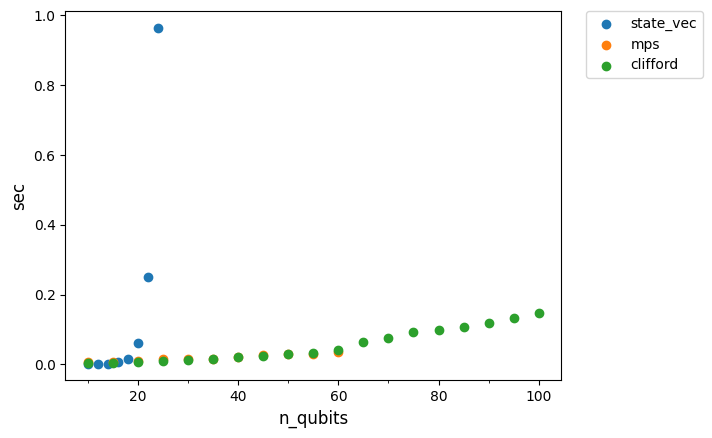

In [28]:
plt.scatter(nqubits_state_vec_list, statevec_exec_time, label="state_vec")
plt.scatter(nqubits_mps_list, mps_exec_time, label="mps")
plt.scatter(nqubits_stab_list, stab_exec_time, label="clifford")
plt.xlabel("n_qubits", fontsize=12)
plt.xticks(np.linspace(10,100,10),minor=True)
plt.ylabel("sec", fontsize=12)
#plt.ylim(0,0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

The stabilizer simulator is fast and can simulate 100 qubits. 
The MPS simulator is slower than the stabilizer simulator, but can simulate 60 qubits. 
The state vector simulator is faster than the MPS simulator below 20 qubits (this depends on the cache size),
but the execution time and memory requirements increase exponentially above 20 qubits.

Here, we compare the simulation time of applying Ising Hamiltonian. 

$
H=h \sum_{i=1}^n X_i + J \sum_{i=1}^n \sum_{j=1}^i Z_iZ_j
$

Using Trotter decomposition,

$
e^{-iH \Delta t} \simeq (\Pi_{j=1}^n e^{-i h X_j \Delta t})(\Pi_{j=1}^n \Pi_{k=1}^{j-1} e^{-i J Z_j Z_k \Delta t})
$

We prepare the initial state as $|+\rangle^{\otimes n}$.

In [29]:
J = np.random.rand()
h = np.random.rand()

delta = 1e-3
def simulating_ising_model(n_qubits, simulator):
    qc = QuantumCircuit(n_qubits, n_qubits)
    # to prepare |+...+>
    for i in range(n_qubits):
        qc.h(i)
    # time-evolution by Ising Hamiltonian
    for i in range(n_qubits):
        qc.rx(-2*(-h*delta), i)
    for i in range(n_qubits):
        for j in range(i):
            qc.rzz(-2*(-J*delta), i, j)
    qc.measure(range(n_qubits), range(n_qubits))
    tcirc = transpile(qc, simulator)
    result = simulator.run(tcirc).result()
    return result.time_taken

nqubits_state_vec_list = [i for i in range(10,25,2)]
nqubits_mps_list = [i for i in range(10,61,5)]
statevec_exec_time = [simulating_ising_model(n_qubits, statevec_simulator) for n_qubits in nqubits_state_vec_list ]
mps_exec_time = [simulating_ising_model(n_qubits, mps_simulator) for n_qubits in nqubits_mps_list]

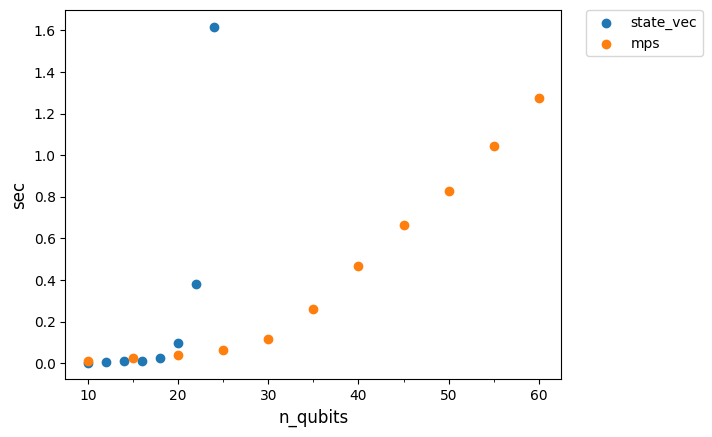

In [30]:
plt.scatter(nqubits_state_vec_list, statevec_exec_time, label="state_vec")
plt.scatter(nqubits_mps_list, mps_exec_time, label="mps")
plt.xlabel("n_qubits", fontsize=12)
plt.xticks(np.linspace(10,60,11),minor=True)
plt.ylabel("sec", fontsize=12)
#plt.ylim(0,1.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

Similar to the previous result, matrix product state simulator allows us to simulate a larger system than state vector simulator. 

## 4 Appendix: Example of Clifford Circuit
Here, we present the exmaples of Clifford circuit. First, we perform 

### 4.1 Simultaneous Measurements

Here, we prepare a random quantum state and evaluate the expectation values using simultaneous measurements. 

In [31]:
angles = np.random.rand(6)*math.pi/2
def qc_exp():
    n_qubits = 2
    qc = QuantumCircuit(n_qubits, n_qubits)
    qc.u(angles[0], angles[1], angles[2], 0) # to prepare a random quantum state 
    qc.u(angles[3], angles[4], angles[5], 1) # to prepare a random quantum state     
    observables = [SparsePauliOp(["XX"]),SparsePauliOp(["YY"]),SparsePauliOp(["ZZ"])]
    estimator = Estimator()
    job = estimator.run([(qc, observables)])
    job_result = job.result()
    return qc, job_result[0].data.evs

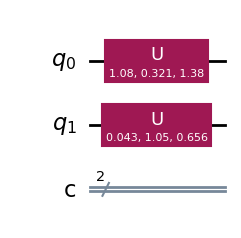

In [33]:
qc_sim1, result_sim1 = qc_exp()
qc_sim1.draw(output="mpl")
plt.show()

In [34]:
print("we've evaluated the expectation values: <psi|XX|psi>=", result_sim1[0], ", <psi|YY|psi>=", result_sim1[1], ", <psi|ZZ|psi>=", result_sim1[2])

we've evaluated the expectation values: <psi|XX|psi>= 0.017774195543390898 , <psi|YY|psi>= 0.010384181336040193 , <psi|ZZ|psi>= 0.4741138528411174


We add CNOT and H gates to the quantum circuit, and the observables are transformed into IZ, -ZZ, and ZI. 

In [35]:
def qc_simultaneous_measurement():
    n_qubits = 2
    qc = QuantumCircuit(n_qubits, n_qubits)
    qc.u(angles[0], angles[1], angles[2], 0) # prepare a random quantum state 
    qc.u(angles[3], angles[4], angles[5], 1) # prepare a random quantum state     
    qc.cx(0, 1)
    qc.h(0)
    # right most is 0th
    observables = [SparsePauliOp(["IZ"],coeffs=[1.0]),SparsePauliOp(["ZZ"],coeffs=[-1.0]),SparsePauliOp(["ZI"],coeffs=[1.0])]
    estimator = Estimator()
    job = estimator.run([(qc, observables)])
    job_result = job.result()
    return qc, job_result[0].data.evs

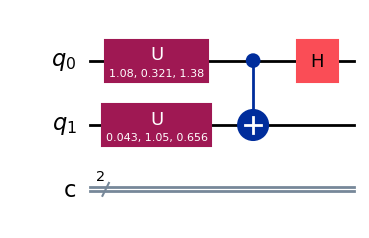

In [36]:
qc_sim2, result_sim2 = qc_simultaneous_measurement()
qc_sim2.draw(output="mpl")
plt.show()

We apply CNOT gate and H gate and evaluate the expectation values with $IZ$, $-ZZ$, $ZI$

In [37]:
print("we've evaluated the expectation values: <psi'|IZ|psi'>=", result_sim2[0], ", <psi'|-ZZ|psi'>=", result_sim2[1], ", <psi'|ZI|psi'>=", result_sim2[2])

we've evaluated the expectation values: <psi'|IZ|psi'>= 0.01777419554339084 , <psi'|-ZZ|psi'>= 0.01038418133604009 , <psi'|ZI|psi'>= 0.4741138528411176


These results are correspond to the previous results. 

Finally, we confirm that we've succeeded to perform simultaneous measurements to evaluate the expectation values using the result of sampling. 

In [38]:
n_qubits = 2
n_shots = int(1e7)
qc = QuantumCircuit(n_qubits, n_qubits)
qc.u(angles[0], angles[1], angles[2], 0) # prepare a random quantum state 
qc.u(angles[3], angles[4], angles[5], 1) # prepare a random quantum state     
qc.cx(0, 1)
qc.h(0)

qc.measure(0,0)
qc.measure(1,1)

sampler = Sampler(default_shots=n_shots)
job = sampler.run([qc])
job_result = job.result()
result_cnt = job_result[0].data.c.get_counts()

print(result_cnt)

{'00': 3704458, '10': 1386139, '01': 3665114, '11': 1244289}


If we describe a quantum state as $|\psi^\prime\rangle=a|00\rangle +b|01\rangle+c|10\rangle+d|11\rangle$, 

we can calculate the expectation values as follows:

$\langle \psi^\prime|I_1 Z_0|\psi^\prime\rangle = a^2-b^2+c^2-d^2$

$\langle \psi^\prime|Z_1 Z_0|\psi^\prime\rangle = a^2-b^2-c^2+d^2$

$\langle \psi^\prime|Z_1 I_0|\psi^\prime\rangle = a^2+b^2-c^2-d^2$

In [39]:
res_iz = result_cnt['00']-result_cnt['01']+result_cnt['10']-result_cnt['11']
res_zz = result_cnt['00']-result_cnt['01']-result_cnt['10']+result_cnt['11']
res_zi = result_cnt['00']+result_cnt['01']-result_cnt['10']-result_cnt['11']
print(res_iz/n_shots, -res_zz/n_shots, res_zi/n_shots)

0.0181194 0.0102506 0.4739144


We have succeeded to evaluate the expectation values of $\langle \psi|XX|\psi \rangle$, $\langle \psi|YY|\psi \rangle$, and $\langle \psi|ZZ|\psi \rangle$.

These expectation values are good approximation of the exact expectation values described above.

From $XZ-ZX \neq O$, we can not simultaneously evaluate the expectation values of $\langle \psi|X|\psi \rangle$ and $\langle \psi|Z|\psi \rangle$. 

A simulator does not care about that, so ,first, we obtain the expectation values of $\langle \psi|X|\psi \rangle$ and $\langle \psi|Z|\psi \rangle$ by the following code. 

In [40]:
n_qubits = 1
qc = QuantumCircuit(n_qubits, n_qubits)
qc.u(angles[0], angles[1], angles[2], 0) # to prepare a random quantum state 
observables = [SparsePauliOp(["X"]),SparsePauliOp(["Z"])]
estimator = Estimator()
job = estimator.run([(qc, observables)])
result = job.result()[0].data.evs
print("<psi|X|psi>=", result[0], "<psi|Z|psi>=", result[1])

<psi|X|psi>= 0.8352228518884052 <psi|Z|psi>= 0.4745529242594718


In [41]:
n_qubits = 1 
n_shots = int(1e6)
qc = QuantumCircuit(n_qubits, n_qubits)
qc.u(angles[0], angles[1], angles[2], 0) # to prepare a random quantum state 
qc.measure(0,0)

sampler = Sampler(default_shots=n_shots)
job = sampler.run([qc])
job_result = job.result()
result_cnt = job_result[0].data.c.get_counts()
print(result_cnt)
print('<psi|Z|psi>=', (result_cnt['0']-result_cnt['1'])/n_shots)

{'0': 737121, '1': 262879}
<psi|Z|psi>= 0.474242


In [42]:
qc = QuantumCircuit(n_qubits, n_qubits)
qc.u(angles[0], angles[1], angles[2], 0) # to prepare a random quantum state 
qc.h(0) # add H gate
qc.measure(0,0)

sampler = Sampler(default_shots=n_shots)
job = sampler.run([qc])
job_result = job.result()
result_cnt = job_result[0].data.c.get_counts()
print(result_cnt)
print('<psi|X|psi>=', (result_cnt['0']-result_cnt['1'])/n_shots)

{'0': 917226, '1': 82774}
<psi|X|psi>= 0.834452


In [43]:
#Check Qiskit version
import qiskit
qiskit.__version__

'2.0.2'